## Taking stock price data of HINDALCO from 05/09/2018 to 06/06/2023

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Reading the dataset

df = pd.read_csv("HINDALCO.NS.csv", parse_dates=["Date"])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-05,233.100006,240.899994,231.300003,239.949997,232.123474,11428802
1,2018-09-06,239.100006,240.399994,234.300003,235.399994,227.721878,7398756
2,2018-09-07,237.000000,246.250000,234.250000,242.550003,234.638672,11021703
3,2018-09-10,242.000000,243.899994,234.850006,235.699997,228.012070,6103496
4,2018-09-11,236.800003,240.800003,228.750000,231.600006,224.045822,12646049


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1171 non-null   datetime64[ns]
 1   Open       1171 non-null   float64       
 2   High       1171 non-null   float64       
 3   Low        1171 non-null   float64       
 4   Close      1171 non-null   float64       
 5   Adj Close  1171 non-null   float64       
 6   Volume     1171 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 64.2 KB


## Test for Stationary

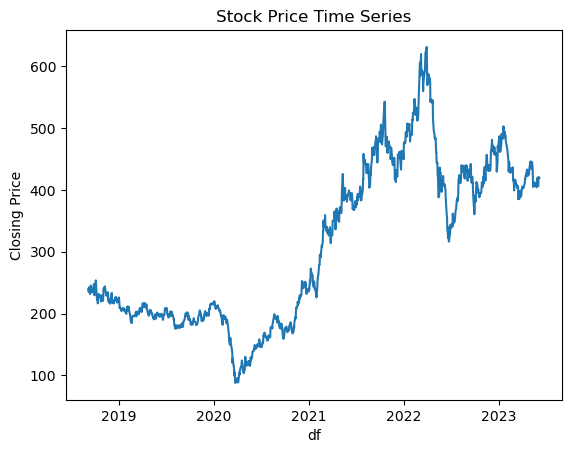

In [5]:
plt.plot(df['Date'], df['Close'])
plt.xlabel("df")
plt.ylabel("Closing Price")
plt.title("Stock Price Time Series")
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
res = adfuller(df["Close"])
print('t-value: ' , res[0])
print('p-value: ' , res[1])

t-value:  -0.9962113628023284
p-value:  0.7546436101228184


In [8]:
df['dff1'] = df['Close'].diff(periods = 1)
df = df.dropna()

In [9]:
res = adfuller(df["dff1"])
print('t-value: ' , res[0])
print('p-value: ' , res[1])

t-value:  -12.826126724110404
p-value:  6.0085951069152204e-24


In [10]:
df['dff2'] = df['Close'].diff(periods = 2)
df = df.dropna()

In [11]:
res = adfuller(df['dff2'])
print('t-value: ', res[0])
print('p-value: ', res[1])

t-value:  -5.848242369161785
p-value:  3.640530493772137e-07


### Another way of testing for stationarity

In [12]:
def perform_adf_test(df):
    result = adfuller(df)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"{key}: {value}")
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is non-stationary.")

In [15]:
train = df.Close[:900]
test = df.Close[900:1001]

In [16]:
perform_adf_test(train)

ADF Statistic: -0.36957488786389187
p-value: 0.9150560880374655
Critical Values:
1%: -3.4377022625762232
5%: -2.8647856243940817
10%: -2.568498194061815
The data is non-stationary.


In [17]:
dff = df[['Date','Close']]
dff.set_index("Date", inplace=True)

In [18]:
dff['diff1'] = dff['Close'] - dff['Close'].shift(1)
dff

C:\Users\DELL\AppData\Local\Temp\ipykernel_25432\6381936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['diff1'] = dff['Close'] - dff['Close'].shift(1)


,Close,diff1
Date,,
2018-09-10,235.699997,NaN
2018-09-11,231.600006,-4.099991
2018-09-12,237.899994,6.299988
2018-09-14,245.449997,7.550003
2018-09-17,241.350006,-4.099991
...,...,...
2023-05-30,413.100006,-6.799988
2023-05-31,405.899994,-7.200012
2023-06-01,406.350006,0.450012


In [19]:
# Checking for null values
dff.isna().sum()

Close    0
diff1    1
dtype: int64

In [20]:
# dropping the null values

dff.dropna(inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_25432\2771259220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.dropna(inplace=True)


In [21]:
# Rechecking

dff.isna().sum()

Close    0
diff1    0
dtype: int64

In [22]:
# Conducting the Augmented Dickey-Fuller test

result1 = adfuller(dff['diff1'])
print(result1)

(-12.808776694053334, 6.5141023825224066e-24, 6, 1160, {'1%': -3.435999853208029, '5%': -2.864034810134692, '10%': -2.5680982944411417}, 8088.895095478012)


<AxesSubplot:xlabel='Date'>

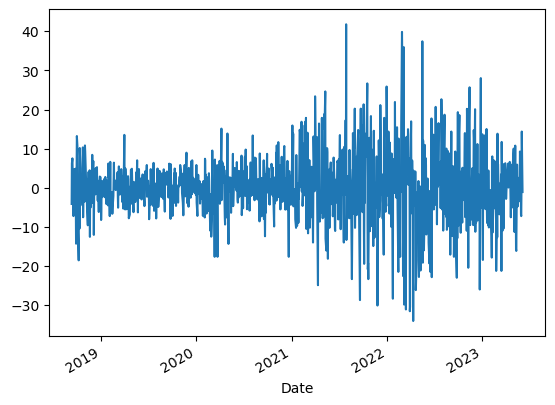

In [23]:
dff['diff1'].plot()

In [24]:
# Splitting the data into train and test

train = dff[:900]
test = dff[900:1001]

In [25]:
dff

,Close,diff1
Date,,
2018-09-11,231.600006,-4.099991
2018-09-12,237.899994,6.299988
2018-09-14,245.449997,7.550003
2018-09-17,241.350006,-4.099991
2018-09-18,234.149994,-7.200012
...,...,...
2023-05-30,413.100006,-6.799988
2023-05-31,405.899994,-7.200012
2023-06-01,406.350006,0.450012


In [26]:
baseline_model = ARIMA(train['Close'], order=(1,1,1))
model_fit = baseline_model.fit()

C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati

In [27]:
baseline_predictions = model_fit.predict(start=len(train), end= len(train) + len(test) - 1)
baseline_predictions

C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


900     444.129575
901     444.128227
902     444.128288
903     444.128285
904     444.128286
           ...    
996     444.128286
997     444.128286
998     444.128286
999     444.128286
1000    444.128286
Name: predicted_mean, Length: 101, dtype: float64

In [28]:
mse = mean_squared_error(test['Close'], baseline_predictions)
mae = mean_absolute_error(test['Close'], baseline_predictions)

In [29]:
test['Close']

Date
2022-05-10    423.000000
2022-05-11    422.549988
2022-05-12    405.850006
2022-05-13    388.000000
2022-05-16    390.950012
                 ...    
2022-09-26    373.399994
2022-09-27    373.600006
2022-09-28    360.750000
2022-09-29    371.200012
2022-09-30    390.549988
Name: Close, Length: 101, dtype: float64

In [30]:
mse

3720.558002264576

In [31]:
mae

49.6183970576993

## ARIMA (1,1,1)

In [32]:
df = pd.read_csv("HINDALCO.NS.csv", parse_dates=["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1171 non-null   datetime64[ns]
 1   Open       1171 non-null   float64       
 2   High       1171 non-null   float64       
 3   Low        1171 non-null   float64       
 4   Close      1171 non-null   float64       
 5   Adj Close  1171 non-null   float64       
 6   Volume     1171 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 64.2 KB


In [33]:
print(train.shape, test.shape)

(900, 2) (101, 2)


In [34]:
# By assigning 'train['Close']' to 'endog', you are creating a new variable 'endog' that will hold the values of the 'Close' column from the 'train' dataframe.

endog = train['Close']

In [35]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [36]:
arima = ARIMA(endog, order=(1,1,1))
results = arima.fit()
results.summary()

C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3129.098
Date:                Thu, 08 Jun 2023   AIC                           6264.197
Time:                        14:35:57   BIC                           6278.601
Sample:                             0   HQIC                          6269.699
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0456      1.383     -0.033      0.974      -2.755       2.664
ma.L1          0.0651      1.381      0.047      0.962      -2.641       2.771
sigma2        61.7639      1.695     36.443      0.000      58.442      65.086
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               659.89
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               7.19   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

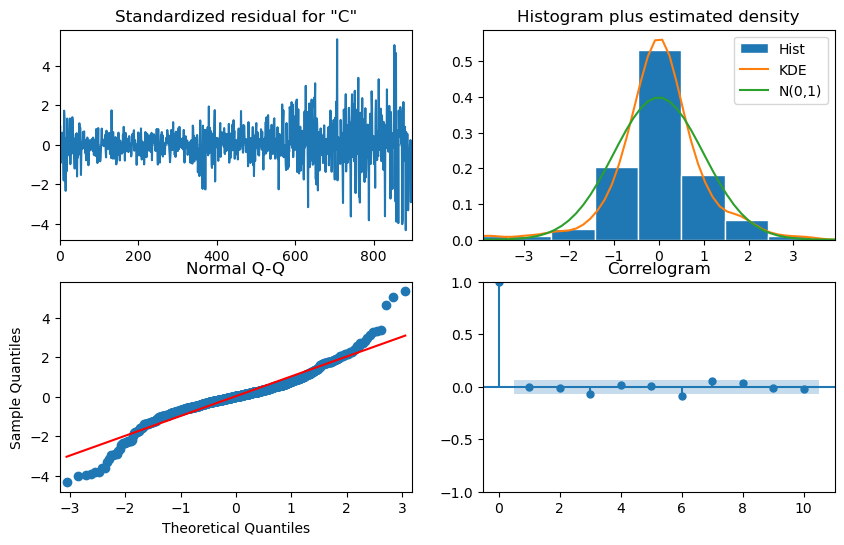

In [37]:
results.plot_diagnostics(figsize=(10,6))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

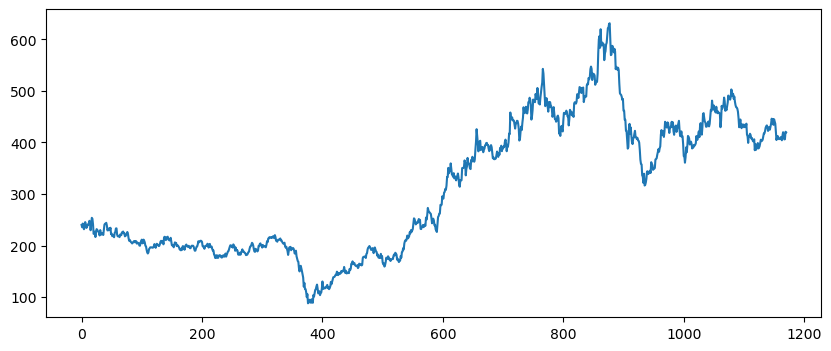

In [38]:
plt.figure(figsize=(10,4))
plt.plot(df['Close'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

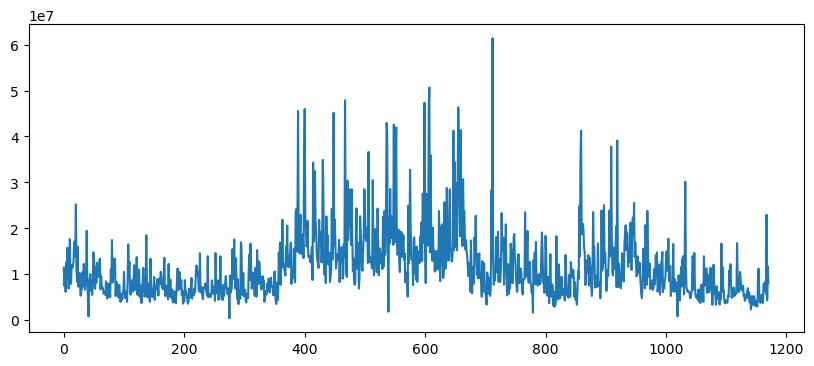

In [39]:
plt.figure(figsize=(10,4))
plt.plot(df['Volume'])
plt.show

## Estimating optimal p, d, q

In [40]:
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [42]:
import itertools
# Split the data into train and test sets
train = df.Close[:900]
test = df.Close[900:1001]

# Define the range of values for p, d, and q parameters
p_values = range(0, 3)  # AR parameter
d_values = range(0, 2)  # Differencing parameter
q_values = range(0, 3)  # MA parameter

# Generate all possible combinations of p, d, and q values
parameter_combinations = list(itertools.product(p_values, d_values, q_values))

# Initialize variables to store best model and its performance
best_model = None
best_aic = np.inf
best_params = None

# Iterate over all parameter combinations
for params in parameter_combinations:
    try:
        # Fit the ARIMA model with current parameter combination
        model = ARIMA(train, order=params)
        model_fit = model.fit()
        
        # Calculate AIC (Akaike Information Criterion)
        aic = model_fit.aic
        
        # Check if the current model has lower AIC than the best model so far
        print(params, aic)
        if aic < best_aic:
            best_aic = aic
            best_model = model_fit
            best_params = params
        
    except:
        continue

# Print the best model parameters and AIC
print("Best Model: ARIMA{}".format(best_params))
print("AIC: {:.2f}".format(best_aic))

(0, 0, 0) 11325.979197242588


C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1) 10155.080328423826


C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2) 9252.504772232647
(0, 1, 0) 6249.126722367818
(0, 1, 1) 6250.797027345472
(0, 1, 2) 6252.4819206366765
(1, 0, 0) 6265.174749392341
(1, 0, 1) 6267.6348280371185
(1, 0, 2) 6269.410137256999
(1, 1, 0) 6250.81041014539
(1, 1, 1) 6252.757595615568


C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2) 6252.632958923534
(2, 0, 0) 6267.615197246165


C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1) 6268.755534443289
(2, 0, 2) 6268.922089556794
(2, 1, 0) 6252.383349458058
(2, 1, 1) 6252.462036935018


C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DELL\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 6243.335188941632
Best Model: ARIMA(2, 1, 2)
AIC: 6243.34


In [43]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3116.668
Date:                Thu, 08 Jun 2023   AIC                           6243.335
Time:                        14:40:00   BIC                           6267.342
Sample:                             0   HQIC                          6252.506
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2715      0.048     -5.686      0.000      -0.365      -0.178
ar.L2         -0.9069      0.044    -20.545      0.000      -0.993      -0.820
ma.L1          0.3215      0.053      6.080      0.000       0.218       0.425
ma.L2          0.8929      0.047     19.139      0.000       0.801       0.984
sigma2        60.0733      1.665     36.078      0.000      56.810      63.337
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):               626.74
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               6.72   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Auto ARIMA

In [44]:
import pandas as pd
import numpy as np
import pmdarima as pm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Split the data into train and test sets
train = df.Close[:900]
test = df.Close[900:1001]

# Step : Optimize the p, d, q values using auto_arima
model = pm.auto_arima(train, start_p=0, d=None, start_q=0,
                      max_p=3, max_d=2, max_q=3, seasonal=False,
                      trace=True, error_action='ignore', suppress_warnings=True)
order = model.order

# Step : Fit the ARIMA model with the optimized order
arima_model = ARIMA(train, order=order)
arima_model_fit = arima_model.fit()

# Step : Forecast the future values
forecast = arima_model_fit.forecast(steps=100)

# Print the best model parameters and AIC
print("Best Model: ARIMA{}".format(order))
print("AIC: {:.2f}".format(arima_model_fit.aic))


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6250.037, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6251.760, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6251.747, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6249.127, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6253.705, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.752 seconds
Best Model: ARIMA(0, 1, 0)
AIC: 6249.13


In [45]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3123.563
Date:                Thu, 08 Jun 2023   AIC                           6249.127
Time:                        14:40:09   BIC                           6253.928
Sample:                             0   HQIC                          6250.961
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        61.0154      1.621     37.650      0.000      57.839      64.192
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               697.53
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               6.96   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Another way

In [46]:
from pmdarima import auto_arima

In [47]:
res = auto_arima(train,
    start_p=0,  d=None,     start_q=0,
    max_p=2,    max_d=2,    max_q=2,
    start_P=0,  D=None,     start_Q=0,
    max_P=2,    max_D=2,    max_Q=2,
    max_order=5, m=12, seasonal=True, trace=True, stepwise=True, random_state=42)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6250.037, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6252.250, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6252.293, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6249.127, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=6250.482, Time=0.58 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=6250.536, Time=0.52 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=6252.433, Time=1.13 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6251.760, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6251.747, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=6253.705, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 4.142 seconds


In [48]:
model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 0, 0, 12), trend = 'c')
results = model.fit(maxiter=200)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  900
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3123.018
Date:                Thu, 08 Jun 2023   AIC                           6250.037
Time:                        14:41:55   BIC                           6259.639
Sample:                             0   HQIC                          6253.705
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2719      0.260      1.044      0.296      -0.238       0.782
sigma2        60.9396      1.618     37.672      0.000      57.769      64.110
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               697.53
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               6.89   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""